# MSSI Tutorial:

### What is MSSI?

Multiscale Spectra Similiarty Index is a spatial measure of gene-gene correlation, desinged to compute imputation accuracy for spatial transcriptomics data. Based on the multi-scale structural similarity index measure (MS-SSIM), MSSI works by iteraivly coarsening the graph of spatial data to generate gene profiles at different resolutions, which are aggregated to a unified score. 


In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0" # Change to -1 if you want to use CPU!

import warnings
warnings.filterwarnings('ignore')


# Install ENVI & MSSI

ENVI & MSSI can be installed directly with pip with the following command:

In [2]:
!pip install scenvi
!pip install mssi

# Importing

In [3]:
import scenvi
import mssi

2024-03-18 19:14:31.038445: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.7 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import scanpy as sc
import colorcet

import umap.umap_ as umap
import sklearn.neighbors
from statannot import add_stat_annotation

# Utility Functions:

Some functions that are used in the analysis in this tutorial, feel free to switch to you own prefered versions

# Data

Downloading Embryogenesis scRNA-seq and seqFISH data from the Pe'er lab aws and loading in with scanpy

In [5]:
!wget https://dp-lab-data-public.s3.amazonaws.com/ENVI_seqFISH/sc_data.h5ad
!wget https://dp-lab-data-public.s3.amazonaws.com/ENVI_seqFISH/st_data.h5ad

In [6]:
st_data = sc.read_h5ad('st_data.h5ad')
sc_data = sc.read_h5ad('sc_data.h5ad')

Defining cell type color palette

In [7]:
cell_type_palette = {'Ex. Endoderm': (0.843137, 0.0, 0.0, 1.0),
 'V. Endoderm': (0.54902, 0.235294, 1.0, 1.0),
 'Pr. Mesoderm': (0.007843, 0.533333, 0.0, 1.0),
 'Allantois': (0.0, 0.67451, 0.780392, 1.0),
 'Neural Crest': (0.596078, 1.0, 0.0, 1.0),
 'HEP': (1.0, 0.498039, 0.819608, 1.0),
 'Ex. Mesoderm': (0.423529, 0.0, 0.309804, 1.0),
 'Notochord': (1.0, 0.647059, 0.188235, 1.0),
 'NMP': (0.345098, 0.231373, 0.0, 1.0),
 'Dermomyotome': (0.0, 0.341176, 0.34902, 1.0),
 'Spine': (0.0, 0.0, 0.866667, 1.0),
 'Ph. Mesoderm': (0.0, 0.992157, 0.811765, 1.0),
 'S. Mesoderm': (0.631373, 0.458824, 0.415686, 1.0),
 'AST': (0.737255, 0.717647, 1.0, 1.0),
 'L.P. Mesoderm': (0.584314, 0.709804, 0.470588, 1.0),
 'P. Mesoderm': (0.752941, 0.015686, 0.72549, 1.0),
 'Sp. Mesoderm': (0.392157, 0.329412, 0.454902, 1.0),
 'D. Endoderm': (0.47451, 0.0, 0.0, 1.0),
 'Mesenchyme': (0.027451, 0.454902, 0.847059, 1.0),
 'Gut': (0.996078, 0.960784, 0.564706, 1.0),
 'Erythroid': (0.0, 0.294118, 0.0, 1.0),
 'S. Ectoderm': (0.560784, 0.478431, 0.0, 1.0),
 'B. Progenitors': (1.0, 0.447059, 0.4, 1.0),
 'PGC': (0.933333, 0.72549, 0.72549, 1.0),
 'C. Mesoderm': (0.368627, 0.494118, 0.4, 1.0),
 'Endothelium': (0.607843, 0.894118, 1.0, 1.0),
 'Brain': (0.92549, 0.0, 0.466667, 1.0),
 'Sclerotome': (0.65098, 0.482353, 0.72549, 1.0),
 'Cr. Mesoderm': (0.352941, 0.0, 0.643137, 1.0),
 'Cardiomyocytes': (0.015686, 0.776471, 0.0, 1.0),
 'I. Mesoderm': (0.619608, 0.294118, 0.0, 1.0),
 'R. N. Ectoderm': (0.611765, 0.231373, 0.313725, 1.0),
 'Other': (0.8117647058823529, 0.7254901960784313, 0.592156862745098, 1)}

## Plotting the Embryogenesis seqFISH 

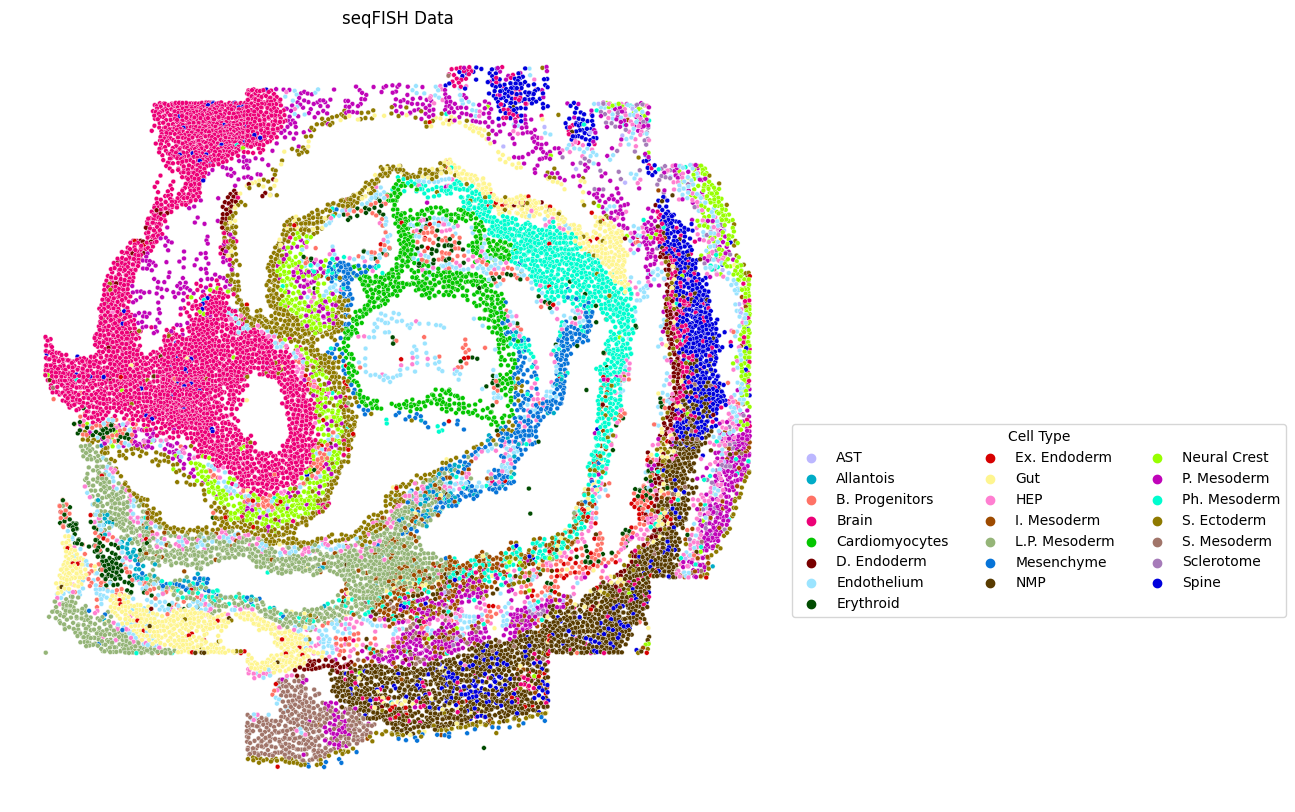

In [8]:
plt.figure(figsize=(10,10))

sns.scatterplot(x = st_data.obsm['spatial'][:, 1], 
                y = -st_data.obsm['spatial'][:, 0], legend = True,
                hue = st_data.obs['cell_type'], 
                s = 12, palette = cell_type_palette)
plt.legend(prop={'size': 10}, ncol = 3, markerscale = 1, fontsize='12', title = 'Cell Type', bbox_to_anchor = [1, 0.5])
plt.axis('off')
plt.title("seqFISH Data")
plt.show()

## Plotting the Motor Cortex scRNAseq

In [9]:
fit = umap.UMAP(
    n_neighbors = 30,
    min_dist = 0.1,
    n_components = 2,
)

sc_data.layers['log'] = np.log(sc_data.X + 1)
sc.pp.highly_variable_genes(sc_data, layer = 'log', n_top_genes = 2048)
sc_data.obsm['UMAP_exp'] = fit.fit_transform(np.log(sc_data[:, sc_data.var['highly_variable']].X + 1))

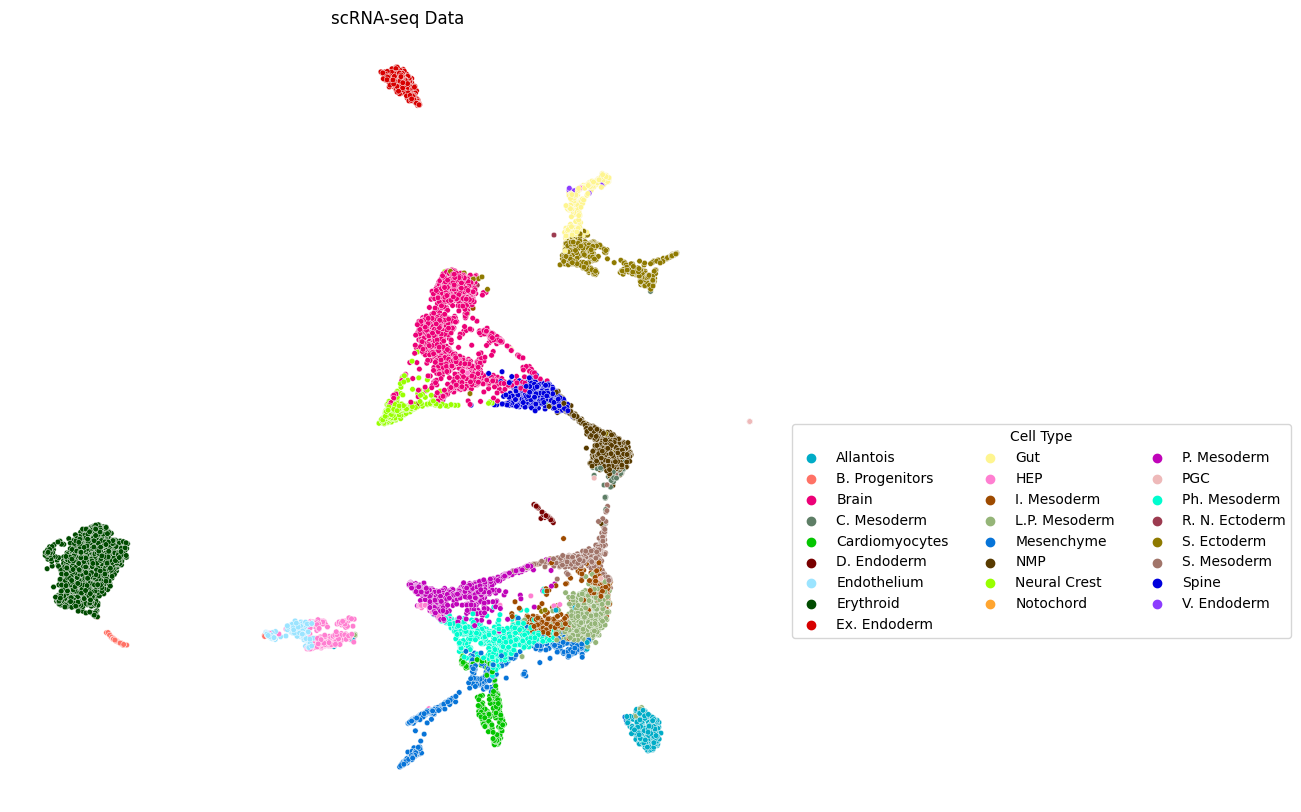

In [10]:
fig = plt.figure(figsize = (10,10))
sns.scatterplot(x = sc_data.obsm['UMAP_exp'][:, 0], y = sc_data.obsm['UMAP_exp'][:, 1],  hue = sc_data.obs['cell_type'], s = 16,
                palette = cell_type_palette, legend = True)
plt.legend(prop={'size': 10}, ncol = 3, markerscale = 1, fontsize='12', title = 'Cell Type', bbox_to_anchor = [1, 0.5])
plt.axis('off')
plt.title('scRNA-seq Data')
plt.show()

# Divide spatial data genes into Test & Train sets

In [11]:
train_genes = np.random.choice(st_data.var_names, int(0.8 * st_data.shape[-1]), replace = False)
test_genes = list(set(st_data.var_names) - set(train_genes))

# Running ENVI

We first define and ENVI model which computes the COVET matrices of the spatial data and intializes the CVAE:

In [12]:
envi_model = scenvi.ENVI(spatial_data = st_data[:, train_genes], sc_data = sc_data, 
                         sc_genes = test_genes) # To force imputation of test genes, even if they are not in the top 2048 HVG of scRNA-seq data

Computing Niche Covariance Matrices
Initializing VAE
Finished Initializing ENVI


Training ENVI and run auxiliary function

In [13]:
envi_model.train()
envi_model.impute_genes()
envi_model.infer_niche()

 spatial: -6.157e-01 sc: -4.042e-01 cov: -3.721e-03 kl: 6.284e-01: 100%|██████████| 16000/16000 [04:33<00:00, 58.49it/s] 


Finished imputing missing gene for spatial data! See 'imputation' in obsm of ENVI.spatial_data


Read ENVI predictions

In [14]:
st_data.obsm['envi_latent'] = envi_model.spatial_data.obsm['envi_latent']
st_data.obsm['COVET'] = envi_model.spatial_data.obsm['COVET']
st_data.obsm['COVET_SQRT'] = envi_model.spatial_data.obsm['COVET_SQRT']
st_data.uns['COVET_genes'] =  envi_model.CovGenes
st_data.obsm['imputation'] = envi_model.spatial_data.obsm['imputation']

sc_data.obsm['envi_latent'] = envi_model.sc_data.obsm['envi_latent']
sc_data.obsm['COVET'] = envi_model.sc_data.obsm['COVET']
sc_data.obsm['COVET_SQRT'] = envi_model.sc_data.obsm['COVET_SQRT']
sc_data.uns['COVET_genes'] =  envi_model.CovGenes

# Imputation Score

First compute the coarsening operations for every scale. mssi.ms_coars caculates downcaled versions of each slice as multiple scales, and returns the per-slice coarsening functions to apply on gene expression vectors and downscaled samples.

In [15]:
import graph_coarsening

In [16]:
coars_ops, coars_graphs = mssi.ms_coars(st_data)

## Plot coarsened data 

In [25]:
gene_plot = np.random.choice(test_genes)

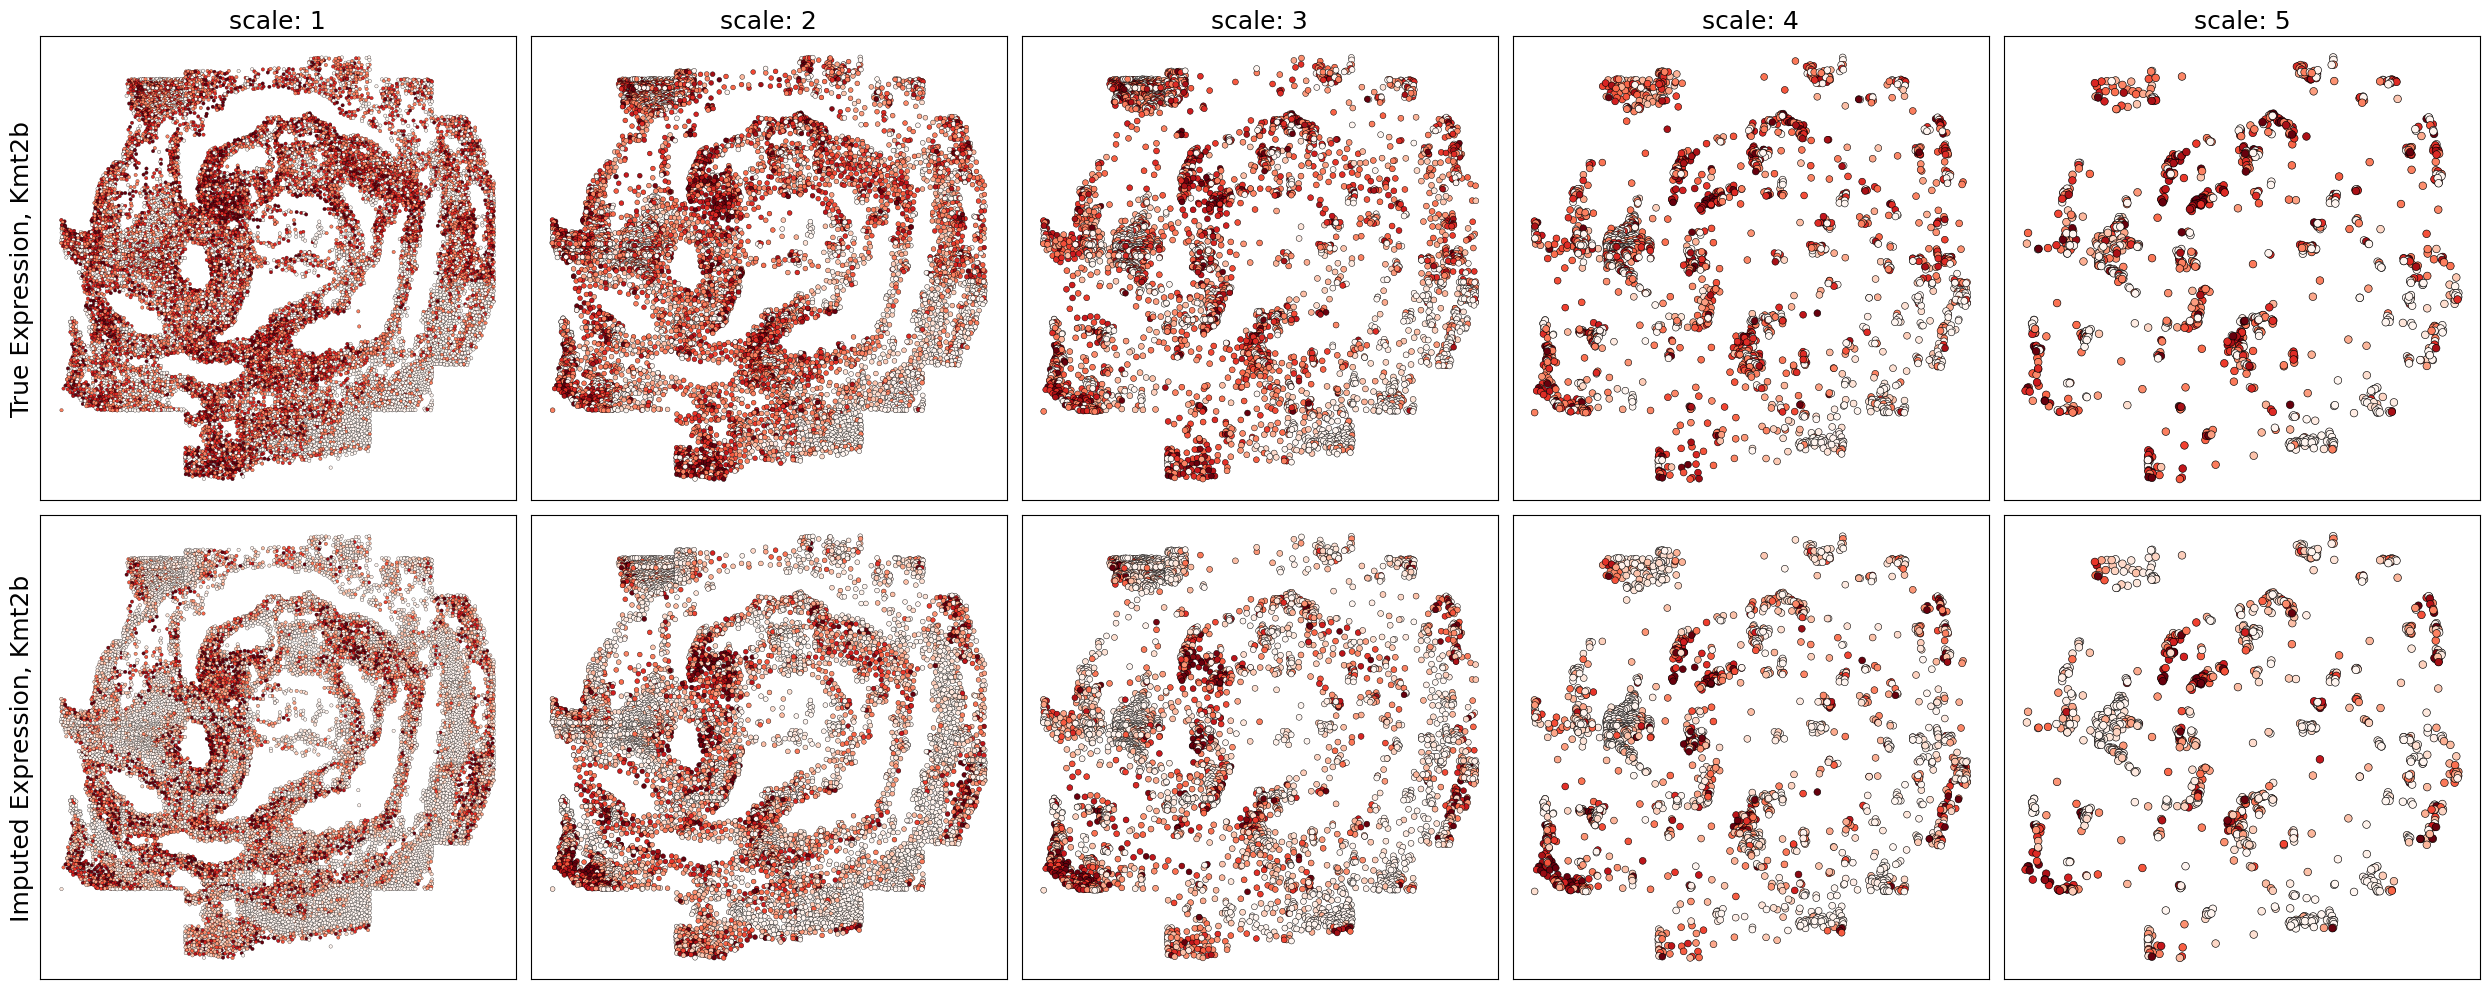

In [26]:
true_multiscale = [np.log(st_data[:, gene].X[:, 0]+1)]
imputed_multiscale = [np.log(st_data.obsm['imputation'][gene]+1)]


for coars_op_scale in coars_ops[0]:
    true_multiscale.append(graph_coarsening.coarsening_utils.coarsen_vector(true_multiscale[-1], coars_op_scale))
    imputed_multiscale.append(graph_coarsening.coarsening_utils.coarsen_vector(imputed_multiscale[-1], coars_op_scale))

plt.figure(figsize=(25, 10))
for ind, graph_scale in enumerate(coars_graphs[0]):
    plt.subplot(2,5,1+ind)
    cvec = true_multiscale[ind]
    sns.scatterplot(x = graph_scale.coords[:, 1], 
                    y = -graph_scale.coords[:, 0], legend = False,  c = cvec, cmap = 'Reds',
                    vmax = np.percentile(cvec, 95), vmin = np.percentile(cvec, 30),
                    s = 6 * (1+ind), edgecolor = 'k')
    plt.title(f'scale: {ind + 1}', fontsize=18)
    if(ind == 0):
        plt.ylabel(f'True Expression, {gene}', fontsize=18)
    #plt.axis('equal')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(2,5,6 + ind)
    cvec = imputed_multiscale[ind]
    sns.scatterplot(x = graph_scale.coords[:, 1], 
                    y = -graph_scale.coords[:, 0], legend = False, c = cvec, cmap = 'Reds',
                    vmax = np.percentile(cvec, 95), vmin = np.percentile(cvec, 30),
                    s = 6 * (1+ind), edgecolor = 'k')
    if(ind == 0):
        plt.ylabel(f'Imputed Expression, {gene}', fontsize=18)
    #plt.axis('equal')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

## Compute MSSI

In [19]:
imputation_score_envi = mssi.MSSI(np.log(st_data[:, test_genes].to_df() + 1), 
                                  np.log(st_data.obsm['imputation'][test_genes] + 1),
                                  coars_ops)

# Benchmark against Harmony

In [20]:
st_data_harmony = st_data[:, train_genes].copy()
sc_data_harmony = sc_data[:, train_genes].copy()

adata_harmony = sc.concat([st_data_harmony, sc_data_harmony])
adata_harmony.obs['technology'] =  st_data_harmony.shape[0]*['spatial'] + sc_data_harmony.shape[0]*['sc']

sc.tl.pca(adata_harmony)
sc.external.pp.harmony_integrate(adata_harmony, 'technology')

latent_sc = adata_harmony[adata_harmony.obs["technology"] == "sc"].obsm['X_pca_harmony']
latent_st = adata_harmony[adata_harmony.obs["technology"] == "spatial"].obsm['X_pca_harmony']

neigh = sklearn.neighbors.KNeighborsRegressor(n_neighbors = int(0.05 * latent_sc.shape[0]))
neigh.fit(latent_sc, np.asarray(sc_data[:, test_genes].X))

st_data.obsm['hy_imputation'] = pd.DataFrame(neigh.predict(latent_st), 
                                             columns = test_genes, index = st_data_harmony.obs_names)


2024-03-18 19:22:38,106 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-03-18 19:22:48,356 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-03-18 19:22:48,448 - harmonypy - INFO - Iteration 1 of 10
2024-03-18 19:22:54,377 - harmonypy - INFO - Iteration 2 of 10
2024-03-18 19:23:00,564 - harmonypy - INFO - Converged after 2 iterations


## Compute Harmony MSSI

In [21]:
imputation_score_harmony = mssi.MSSI(np.log(st_data[:, test_genes].to_df() + 1), 
                                     np.log(st_data.obsm['hy_imputation'][test_genes] + 1),
                                      coars_ops)

# Visualize Scores

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

ENVI v.s. Harmony: t-test paired samples with Bonferroni correction, P_val=4.063e-09 stat=6.732e+00


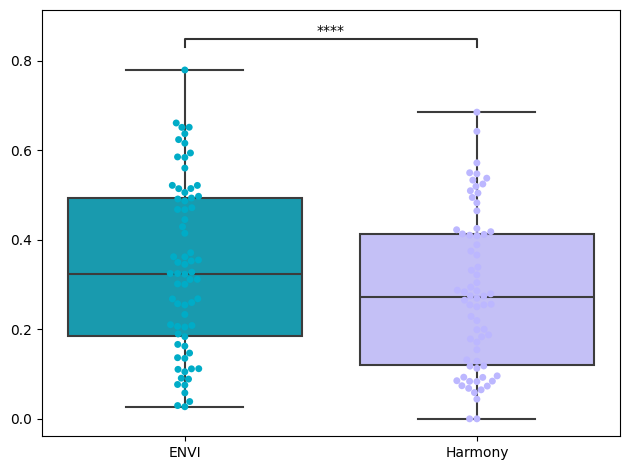

In [22]:
score_df = pd.DataFrame(np.asarray([imputation_score_envi.loc['MSSI'], imputation_score_harmony.loc['MSSI']]).T,
                                   columns = ['ENVI', 'Harmony'], index = imputation_score_envi.columns)

ax = sns.boxplot(data = score_df, palette = {'ENVI': (0.0, 0.67451, 0.780392, 1.0), 'Harmony': (0.737255, 0.717647, 1.0, 1.0)})
sns.swarmplot(data = score_df, palette = {'ENVI': (0.0, 0.67451, 0.780392, 1.0), 'Harmony': (0.737255, 0.717647, 1.0, 1.0)})
add_stat_annotation(ax, data=score_df,
                    box_pairs=[("ENVI", "Harmony")],
                    test='t-test_paired', text_format='star', loc='inside', verbose=2)
plt.xticks([0,1], ['ENVI', 'Harmony'])

plt.tight_layout()
plt.show()